In [1]:
import torch
import torch.nn as nn
from torchvision import transforms as T

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from typing import Tuple, List, Dict, Any, Union

from data import RatDataset
from model import AutoEncoder, Encoder, Decoder


In [2]:
image_folder = "images"

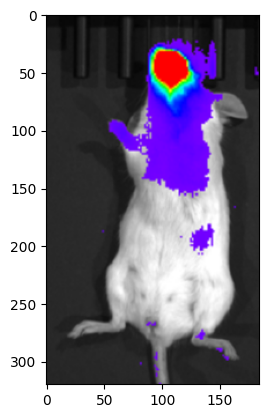

In [3]:
image = Image.open(os.path.join(image_folder, "Bilde1.png")).convert('RGB')
resized_image = T.functional.resize(image, (320, 184))

plt.imshow(resized_image)
plt.show()

In [4]:
channels = [3, 16, 32, 64, 128, 256]
kernel_sizes = [7, 5, 5, 3, 3]
strides = [2, 2, 2, 1, 1]
paddings = [3, 2, 2, 1, 1]
hidden_dims = [256, 256, 256]
output_dim = 128

encoder = Encoder(channels, kernel_sizes, strides, paddings, hidden_dims, output_dim)
print(encoder)

Encoder(
  (conv_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (relu): ReLU()
    )
    (2): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (relu): ReLU()
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
  )
  (fc_layers): ModuleList(
    (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)


In [5]:
fc_dims = [128, 256, 512, 1024, 3*320*184]

decoder = Decoder(fc_dims)
print(decoder)

Decoder(
  (fc_layers): ModuleList(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): Linear(in_features=1024, out_features=176640, bias=True)
  )
)


In [6]:
np_image = np.array(resized_image)
torch_image = torch.Tensor(np_image).reshape(1, 3, 320, 184)

print(torch_image.shape)

out = encoder(torch_image)
print(out.shape)

back = decoder(out)
print(back.shape)

torch.Size([1, 3, 320, 184])
torch.Size([1, 128])
torch.Size([1, 3, 320, 184])


In [7]:
autoencoder = AutoEncoder(encoder, decoder)

out, latent = autoencoder(torch_image)

print(latent.shape)
print(out.shape)

torch.Size([1, 128])
torch.Size([1, 3, 320, 184])


In [8]:
hparams = {
    "batch_size": 1,
    "shuffle": True,
    "num_workers": 4,
    "epochs": 100
}

In [9]:
print(autoencoder)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

AutoEncoder(
  (encoder): Encoder(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (conv): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (relu): ReLU()
      )
      (1): ConvBlock(
        (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (relu): ReLU()
      )
      (2): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (relu): ReLU()
      )
      (3): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
      )
    )
    (fc_layers): ModuleList(
      (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (fc_layers): ModuleList(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=512, bias=True)
      (2): Linear(in_features=512, o

In [10]:
transform = T.Compose([
    T.Resize((320, 184)),
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomApply(transforms=[T.GaussianBlur(kernel_size=5)], p=0.5), # Randomly apply Gaussian blur
])


In [11]:
dataset = RatDataset(image_folder, transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=hparams["batch_size"], shuffle=hparams["shuffle"], num_workers=hparams["num_workers"])

In [12]:
for epoch in range(hparams["epochs"]):
    for image_batch in dataloader:
    
        out, latent = autoencoder(image_batch)
        loss = loss_fn(out, image_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch}, Loss: {loss.item()}")

KeyboardInterrupt: 